In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy
import re

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.neighbors import KernelDensity
import torch
print(torch.cuda.is_available())
from statsmodels.stats.weightstats import _zstat_generic

import models
import dre
import rna
from calibrate import rectified_p_value
import vae
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

PATH = '/homefs/home/wongfanc/density-ratio-estimation'

True


2024-12-10 20:24:47.291363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 20:24:47.291396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 20:24:47.292589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 20:24:47.299615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 20:24:49.072285: W tensorflow/comp

In [2]:
# load training, calibration, and models
noise_sd = 0.02
p_mut = 4 / 50
n_hidden = 100
n_filters = 32

# load calibration data
fname = os.path.join(PATH, 'rna-results', 'calibration-pm{:.2f}-nsd{:.2f}-040524.npz'.format(p_mut, noise_sd))
d = np.load(fname)
calseqs_n = list(d['calseqs_n'])
ycal_n = d['ycal_n']

# load training data
data_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz'
d = np.load(data_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
print(f'Loaded {ytrain_n.size} training points from {data_fname}.\n')

# train ridge regression 
ridge = ridge = models.RidgeRegressor(seq_len=50, alphabet=rna.RNA_NUCLEOTIDES)
ridge.fit(trainseq_n, ytrain_n)

# load trained FF and CNN models
model_and_data_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'

ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, rna.RNA_NUCLEOTIDES, n_hidden)
ff.load(ff_fname)

cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, rna.RNA_NUCLEOTIDES, n_filters, n_hidden)
cnn.load(cnn_fname)

name2model = {
    'ridge': ridge,
    'ff': ff,
    'cnn': cnn
}

Loaded 5000 training points from /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz.



In [50]:
# sample new designs (only for low n_design)
# need viennaenv for this cell
reload(designers)

n_design = 2000
seed_seq = rna.RNABinding.SEEDS[3]
max_mu = 2
temperatures = [0.05, 0.03, 0.02, 0.01, 0.005]
n_trust_radius_mutations = 5
n_step = 2000
print_every = 500
model_name = 'ridge'

model = name2model[model_name]
biswas = designers.Biswas(model, trainseq_n)
landscape = rna.RNABinding(noise_sd=noise_sd)
name2designdata = {}

for temp in temperatures:
    temp = round(temp, 4)

    designseq_n, _, _ = biswas.design_sequences(
        n_design,
        seed_seq,
        max_mu,
        temp,
        n_trust_radius_mutations,
        n_step,
        print_every
    )
    
    preddesign_n = model.predict(designseq_n)
    ydesign_n = landscape.get_fitness(designseq_n)
    
    name2designdata['biswas-{}-{}'.format(model_name, temp)] = (designseq_n, ydesign_n, preddesign_n)
    
    print('temp = {:.3f}, mean prediction {:.3f}, mean label {:.3f}'.format(
        temp, np.mean(preddesign_n), np.mean(ydesign_n)
    ))


Initialization. Mean, SD prediction: 0.286, 0.027.
Step 500. Mean, SD acceptance probability: 0.080, 0.255. Mean, SD prediction: 0.310, 0.034. (77 s)
Step 1000. Mean, SD acceptance probability: 0.075, 0.249. Mean, SD prediction: 0.313, 0.036. (155 s)
Step 1500. Mean, SD acceptance probability: 0.080, 0.256. Mean, SD prediction: 0.317, 0.038. (233 s)
Step 2000. Mean, SD acceptance probability: 0.087, 0.266. Mean, SD prediction: 0.320, 0.040. (311 s)
temp = 0.050, mean prediction 0.320, mean label 0.303
Initialization. Mean, SD prediction: 0.285, 0.025.
Step 500. Mean, SD acceptance probability: 0.083, 0.256. Mean, SD prediction: 0.321, 0.032. (77 s)
Step 1000. Mean, SD acceptance probability: 0.079, 0.249. Mean, SD prediction: 0.327, 0.035. (156 s)
Step 1500. Mean, SD acceptance probability: 0.076, 0.243. Mean, SD prediction: 0.331, 0.038. (234 s)
Step 2000. Mean, SD acceptance probability: 0.081, 0.250. Mean, SD prediction: 0.336, 0.039. (311 s)
temp = 0.030, mean prediction 0.336, mea

In [51]:
name2designdata['train'] = (trainseq_n + calseqs_n, np.hstack([ytrain_n, ycal_n]), None)

biswas-ridge-0.05 2000
biswas-ridge-0.03 2000
biswas-ridge-0.02 2000
biswas-ridge-0.01 2000
biswas-ridge-0.005 2000
train 10000


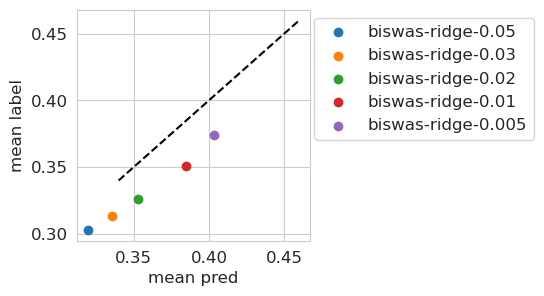

In [52]:
# scatter mean prediction vs. mean label
plt.figure(figsize=(3, 3))
for name, data in name2designdata.items():
    print(name, len(data[0]))
    if name != 'train':
        plt.scatter(np.mean(data[2]), np.mean(data[1]), label=name)
plt.xlabel('mean pred'); plt.ylabel('mean label');
plt.legend(bbox_to_anchor=(2, 1))
plt.plot([0.34, 0.46], [0.34, 0.46], '--k');

In [4]:
# 04/18 checking progress of Biswas radius 5 designs
design_pkl_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-results/designs-biswas-041824.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)
for name, data in name2designdata.items():
    print(name, data[1].size)

biswas-ridge-0.05 50000
biswas-ridge-0.03 50000
biswas-ridge-0.02 50000
biswas-ridge-0.01 50000
biswas-ridge-0.005 50000
biswas-ff-0.05 50000
biswas-ff-0.03 50000
biswas-ff-0.02 50000
biswas-ff-0.01 50000
biswas-ff-0.005 50000
biswas-cnn-0.05 50000
biswas-cnn-0.03 50000
biswas-cnn-0.02 50000
biswas-cnn-0.01 50000
biswas-cnn-0.005 50000


In [25]:
# 04/24: checking progress of n_step = 1000 Biswas
design_pkl_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-results/designs-biswas-042424.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)

for name, data in name2designdata.items():
    print(name, len(data[0]))

biswas-ridge-0.05 50000
biswas-ridge-0.03 50000
biswas-ridge-0.02 50000
biswas-ridge-0.01 50000
biswas-ridge-0.005 50000
pex-ridge 50000
biswas-ff-0.05 50000
biswas-ff-0.03 50000
biswas-ff-0.02 50000
biswas-ff-0.01 50000
biswas-ff-0.005 50000
pex-ff 50000
biswas-cnn-0.05 50000
biswas-cnn-0.03 50000
biswas-cnn-0.02 50000
biswas-cnn-0.01 50000
biswas-cnn-0.005 50000
pex-cnn 50000


# load pre-sampled and pre-labeled designs!

In [3]:
# more calibration data
cal_trial_idx = 100

with open('/data/wongfanc/rna-data/calibration-pm0.08-nsd0.02_041524_2.pkl', 'rb') as f:
    caldata_t = pickle.load(f)
calseqs_n, ycal_n = caldata_t[cal_trial_idx]

adalead-ridge-0.2 50000 0.39977417242645885
adalead-ridge-0.1 50000 0.4169698535697744
adalead-ridge-0.05 50000 0.4319277238698562
adalead-ridge-0.01 50000 0.4280154131378181
adalead-ridge-0.15 50000 0.4096429999482224
train 5000 None


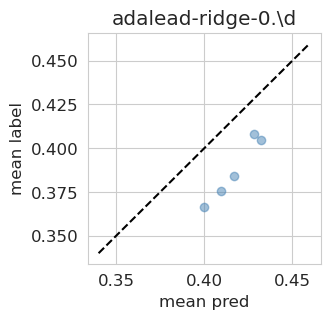

In [5]:
design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'
model_name = 'ridge'
regex_str = 'adalead-{}-0.\d'.format(model_name)
regex = re.compile(regex_str)

name2color = {
    'ridge': 'steelblue',
    'ff': 'orange',
    'cnn': 'green'
}
with open(design_pkl_fname, 'rb') as f:
    name2designdata_all = pickle.load(f)
    
name2designdata = {
    name: data for name, data in name2designdata_all.items()
    if regex.match(name) is not None and
    '0.5' not in name and '0.45' not in name and
    '0.4' not in name and '0.35' not in name and
    '0.3' not in name and '0.25' not in name
}
# trainpred_n = name2model[model_name].predict(trainseq_n)
# calpred_n = name2model[model_name].predict(calseqs_n)
# name2designdata['train'] = (
#     trainseq_n + calseqs_n,
#     np.hstack([ytrain_n, ycal_n]),
#     np.hstack([trainpred_n, calpred_n])
# )
name2designdata['train'] = (trainseq_n, ytrain_n, None)
    
plt.figure(figsize=(3, 3))
for name, data in name2designdata.items():
    print(name, len(data[0]), np.mean(data[2]) if name != 'train' else None)
    if name != 'train':
        for n, color in name2color.items():
            if n in name:
                break
        plt.scatter(np.mean(data[2]), np.mean(data[1]), c=color, alpha=0.5)
plt.xlabel('mean pred'); plt.ylabel('mean label');
plt.plot([0.34, 0.46], [0.34, 0.46], '--k');
plt.title(regex_str);

In [25]:
params = list(mdre.idx2mdre[0].model.parameters())

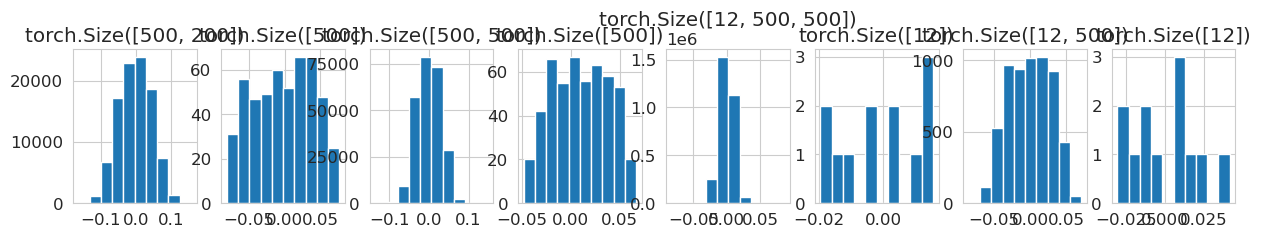

In [30]:
plt.figure(figsize=(15, 2))
for i, thing in enumerate(params):
    plt.subplot(1, len(params), i + 1)
    plt.hist(thing.cpu().numpy().flatten())
    plt.title(thing.shape)

In [14]:
# DRE
reload(dre)

noise_sd = 0
weight_decay = 0
n_hidden = 256
n_epoch = 100
weight_loss = True
lr = 1e-3
device = torch.device('cuda')

# 'adalead-ridge-0.[0-9]{2}$'
# 'biswas-ridge-0.*[0|1|3|5]$'
# 'biswas-ridge-0.*[0|2|4|8]'
mdre_group_regex_strs = [
    'adalead-ridge-0.\d',
]


mdre = dre.MultiMDRE(
    mdre_group_regex_strs,
    device=device
)

mdre.fit(
    list(name2designdata.keys()),
    name2designdata,
    noise_sd=noise_sd,
    lr=lr,
    weight_loss=weight_loss,
    weight_decay=weight_decay,
    n_hidden=n_hidden,
    n_epoch=n_epoch,
    verbose=True
)
loss_df = mdre.idx2lossdf[0]

# mdre = dre.MultinomialLogisticRegresssionDensityRatioEstimator(
#     50,
#     len(name2designdata.keys()),
#     n_hidden,
#     device=device
# )
# loss_df = mdre.fit(
#     name2designdata,
#     n_epoch,
#     lr=lr,
#     verbose=True
# )

Fitting MDRE for adalead-ridge-0.\d, which has 5 design algorithms:
train
adalead-ridge-0.2
adalead-ridge-0.1
adalead-ridge-0.05
adalead-ridge-0.01
adalead-ridge-0.15
One-hot-encoding all 6 categories of sequences...
  Done. (4 s)


100%|████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.13it/s]

Min train loss 0.73, min val loss 0.69



In [61]:
def calibrate_density_ratios(caldr_n, designdr_n, bandwidth: float = 1.):
    caldr_nx1 = np.fmax(caldr_n[:, None], 1e-16)
    calkde = KernelDensity(bandwidth=bandwidth, kernel='gaussian', metric='euclidean')
    calkde.fit(np.log(caldr_nx1))
    logpcal_n = calkde.score_samples(np.log(caldr_nx1))
    
    designdr_nx1 = np.fmax(designdr_n[:, None], 1e-16)
    designkde = KernelDensity(bandwidth=bandwidth, kernel='gaussian', metric='euclidean')
    designkde.fit(np.log(designdr_nx1))
    logpdesign_n = designkde.score_samples(np.log(caldr_nx1))
    
    return np.exp(logpdesign_n - logpcal_n)

In [55]:
design_name = 'adalead-ridge-0.4'
designseq_n, ydesign_n, preddesign_n = name2designdata[design_name]

# traindr_n = mdre.get_dr(trainseq_n, design_name, self_normalize=False)
caldr_n = mdre.get_dr(calseqs_n, design_name, self_normalize=False)
designdr_n = mdre.get_dr(designseq_n, design_name, self_normalize=False)

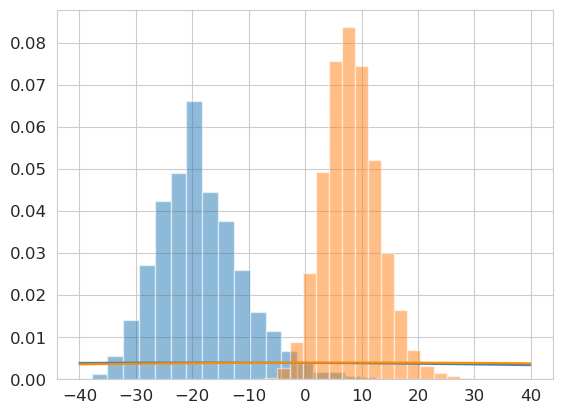

In [41]:
bandwidth = 100
xs = np.arange(-40, 40, 0.1)[:, None]
plt.hist(np.log(caldr_n), alpha=0.5, bins=20, log=False, density=True);
plt.hist(np.log(designdr_n), alpha=0.5, bins=20, log=False, density=True);

calkde = KernelDensity(bandwidth=bandwidth, kernel='gaussian', metric='euclidean')
calkde.fit(np.log(caldr_n)[:, None])
pcal_n = np.exp(calkde.score_samples(xs))

designkde = KernelDensity(bandwidth=bandwidth, kernel='gaussian', metric='euclidean')
designkde.fit(np.log(designdr_n)[:, None])
pdesign_n = np.exp(designkde.score_samples(xs))

plt.plot(xs, pcal_n, c='steelblue')
plt.plot(xs, pdesign_n, c='darkorange')

(0.0, 1.0)

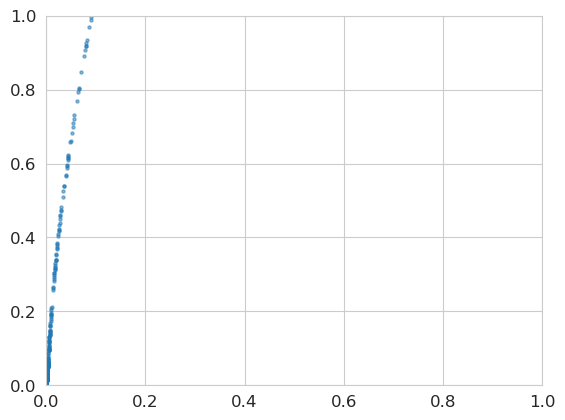

In [58]:
bandwidth = 1

caldr_nx1 = np.fmax(caldr_n[:, None], 1e-16)

calkde = KernelDensity(bandwidth=bandwidth, kernel='gaussian', metric='euclidean')
calkde.fit(np.log(caldr_nx1))
logpcal_n = calkde.score_samples(np.log(caldr_nx1))

designkde = KernelDensity(bandwidth=bandwidth, kernel='gaussian', metric='euclidean')
designkde.fit(np.log(designdr_n)[:, None])
logpdesign_n = designkde.score_samples(np.log(caldr_nx1))

logdr_n = logpdesign_n - logpcal_n

# plt.hist(logpcal_n, alpha=0.5, bins=20, log=True, density=True);
# plt.hist(logpdesign_n, alpha=0.5, bins=20, log=False, density=True);
# plt.hist(logdr_n, alpha=0.5, bins=20, log=False, density=True);

In [18]:
# point estimates using DR
alpha = 0.1
self_normalize = True
bandwidth = 1
target_values = np.arange(0.3, 0.51, 0.01)

# get DRs for each design distribution
# calpred_n = name2model[model_name].predict(calseqs_n)
designname2dr = {
    name: mdre.get_dr(calseqs_n, name, self_normalize=self_normalize)
    for name in name2designdata.keys() if name != 'train'
}

imp_target2name = {val: [] for val in target_values}
pp_target2name = {val: [] for val in target_values}
pointest_mx3 = np.zeros([len(name2designdata), 3])
ciwidth_mx2 = np.zeros([len(name2designdata), 2])
model = name2model[model_name]

for i, data in enumerate(name2designdata.items()):
    
    design_name, (designseq_n, ydesign_n, preddesign_n) = data
    
    if design_name != 'train':
        print(design_name)
        
        imputed_mean = np.mean(preddesign_n)
        imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)
        
        caldr_n = designname2dr[design_name]
#         designdr_n = mdre.get_dr(designseq_n, design_name, self_normalize=self_normalize)
#         caldr_n = calibrate_density_ratios(caldr_n, designdr_n, bandwidth=bandwidth)
        
        predcal_n = model.predict(calseqs_n)
        rect_n = caldr_n * (ycal_n - predcal_n)
        rectifier_mean = np.mean(rect_n)
        rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
        pointest_mx3[i] = np.mean(ydesign_n), np.mean(preddesign_n) + rectifier_mean, np.mean(preddesign_n)
        
        pp_se = np.maximum(np.sqrt(imputed_se ** 2 + rectifier_se ** 2), 1e-16)
        ciwidth_mx2[i] = pp_se, imputed_se

        print('{:.3f} {:.3f} {:.3f}'.format(
            np.mean(ydesign_n), np.mean(preddesign_n), np.mean(preddesign_n) + rectifier_mean
        ))
        
        for target_val in target_values:

            # run imputation hypothesis test
            imp_pval = _zstat_generic(
                imputed_mean,
                0,
                imputed_se,
                alternative='larger',
                diff=target_val
            )[1]

            # run prediction-powered hypothesis test
            pp_pval = rectified_p_value(
                rectifier_mean,
                rectifier_se,
                imputed_mean,
                imputed_se,
                null=target_val,
                alternative='larger'
            )

            # Bonferroni correction
            if imp_pval < alpha / (len(name2designdata) - 1):
                imp_target2name[target_val].append(design_name)
                
            if pp_pval < alpha / (len(name2designdata) - 1):
                pp_target2name[target_val].append(design_name)
    else:
        train_idx = i
pointest_mx3 = np.delete(pointest_mx3, train_idx, axis=0)
ciwidth_mx2 = np.delete(ciwidth_mx2, train_idx, axis=0)

adalead-ridge-0.2
0.366 0.400 0.385
adalead-ridge-0.1
0.384 0.417 0.390
adalead-ridge-0.05
0.405 0.432 0.442
adalead-ridge-0.01
0.408 0.428 0.443
adalead-ridge-0.15
0.376 0.410 0.390


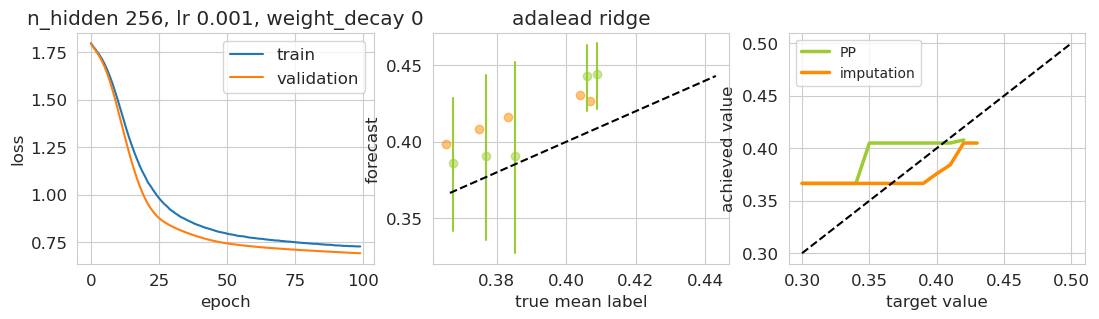

In [19]:
# run preliminary selection experiments and plot
title = f'adalead {model_name}'
ppoff = 0.001
impoff = -0.001

impach_t = []
ppach_t = []
xy_lim = [np.min(target_values), np.max(target_values)]

for val in target_values:
    names = imp_target2name[val]
    imp_truemeans = [np.mean(name2designdata[name][1]) for name in names]
    if len(imp_truemeans):
        impach_t.append(np.min(imp_truemeans))
    else:
        impach_t.append(np.nan)
    
    names = pp_target2name[val]
    pp_truemeans = [np.mean(name2designdata[name][1]) for name in names]
    if len(pp_truemeans):
        ppach_t.append(np.min(pp_truemeans))
    else:
        ppach_t.append(np.nan)

plt.figure(figsize=(13, 3))
plt.subplot(131)
plt.title('n_hidden {}, lr {}, weight_decay {}'.format(n_hidden, lr, weight_decay))
plt.plot(loss_df['train_loss'], label='train')
plt.plot(loss_df['val_loss'], label='validation')
plt.legend() 
plt.xlabel('epoch');
plt.ylabel('loss');

plt.subplot(132)
plt.scatter(pointest_mx3[:, 0] + ppoff, pointest_mx3[:, 1] + ppoff, label='PP', c='yellowgreen', alpha=0.5)
plt.scatter(pointest_mx3[:, 0] + impoff, pointest_mx3[:, 2] + impoff, label='imputation', c='darkorange', alpha=0.5) 
for pe_x3, ciw_x2 in zip(pointest_mx3, ciwidth_mx2):
    plt.plot([pe_x3[0] + ppoff, pe_x3[0] + ppoff], [pe_x3[1] - 2 * ciw_x2[0], pe_x3[1] + 2 * ciw_x2[0]], c='yellowgreen')
    plt.plot([pe_x3[0] + impoff, pe_x3[0] + impoff], [pe_x3[2] - 2 * ciw_x2[1], pe_x3[2] + 2 * ciw_x2[1]], c='darkorange')

plt.plot([np.min(pointest_mx3), np.max(pointest_mx3)], [np.min(pointest_mx3), np.max(pointest_mx3)], '--k');
plt.xlabel('true mean label');
plt.ylabel('forecast');
plt.title(title);

plt.subplot(133)
plt.plot(target_values, ppach_t, label='PP', c='yellowgreen', linewidth=2.5)
plt.plot(target_values, impach_t, label='imputation', c='darkorange', linewidth=2.5)
plt.plot(xy_lim, xy_lim, '--k');
plt.xlabel('target value');
plt.ylabel('achieved value');
plt.legend(fontsize=10);



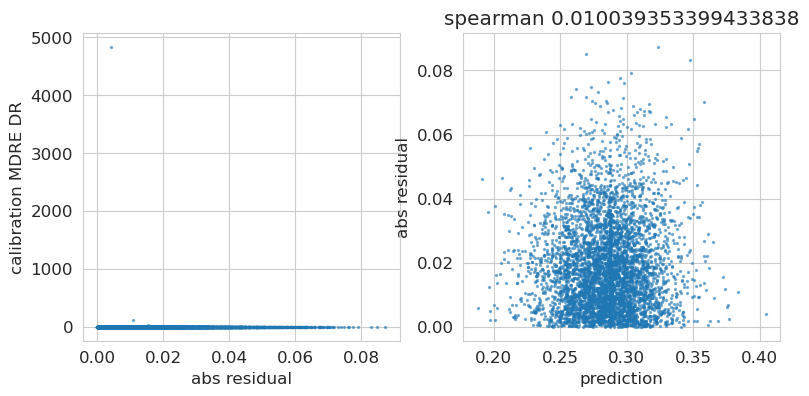

In [15]:
name = 'adalead-ridge-0.5'
caldr_n = designname2dr[name]
predcal_n = model.predict(calseqs_n)

rescal_n = np.abs(ycal_n - predcal_n)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(rescal_n, caldr_n, s=2, alpha=0.5);
plt.xlabel('abs residual');
plt.ylabel('calibration MDRE DR');
plt.subplot(122)
r, _ = sc.stats.spearmanr(predcal_n, rescal_n)
plt.scatter(predcal_n, rescal_n, s=2, alpha=0.5);
plt.title(f'spearman {r}');
plt.ylabel('abs residual');
plt.xlabel('prediction');

In [112]:
# cannot contain any groups that don't have any data from name2designdata
# MDRE.fit() will throw error
mdre_group_regex_strs = [
    'adalead-ridge-0.\d',
    'adalead-ff-0.\d',
    'adalead-cnn-0.\d',
    'biswas-ridge-0.\d',
    'biswas-ff-0.\d',
    'biswas-cnn-0.\d',
    'dbas-ff-0.\d',
    'dbas-cnn-0.\d',
    'pex-ridge',
    'pex-ff',
    'pex-cnn',
    'dbas-ridge-0.1t\d',
    'dbas-ridge-0.2t\d',
    'cbas-ridge-0.1t\d',
    'cbas-ridge-0.2t\d',
    'cbas-ridge-0.3t\d',
    'cbas-ridge-0.4t\d',
    'cbas-ridge-0.5t\d',
    'cbas-ridge-0.6t\d',
    'cbas-ridge-0.7t\d',
    'cbas-ridge-0.8t\d',
    'cbas-ridge-0.9t\d',
    'cbas-ff-0.1',
    'cbas-ff-0.2',
    'cbas-ff-0.3',
    'cbas-ff-0.4',
    'cbas-ff-0.5',
    'cbas-ff-0.6',
    'cbas-ff-0.7',
    'cbas-ff-0.8',
    'cbas-ff-0.9',
    'cbas-cnn-0.1',
    'cbas-cnn-0.2',
    'cbas-cnn-0.3',
    'cbas-cnn-0.4',
    'cbas-cnn-0.5',
    'cbas-cnn-0.6',
    'cbas-cnn-0.7',
    'cbas-cnn-0.8',
    'cbas-cnn-0.9',
    'vae-ridge'
]

In [ ]:
# selection experiments
reload(dre)
reload(rna)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae-ridge']
# cbas ridge
for q in cbas_dbas_quantiles:
    q = round(q, 2)
    design_names.append(f'cbas-ridge-{q}t19')

# dbas ridge
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        # cbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'cbas-{model_name}-{q}')
        
        # dbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')
    

design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
cal_pkl_fname = '/data/wongfanc/rna-data/calibration-pm0.08-nsd0.02_041524_2.pkl'
target_values = np.arange(0.25, 0.501, 0.001)
n_trial = 200
n_mdre_hidden = 500
n_mdre_epoch = 500
pp_csv_fname = '/data/wongfanc/rna-results/selection-pp-112524-2.csv'
cp_csv_fname = '/data/wongfanc/rna-results/selection-cp-112524-2.csv'
device = torch.device('cuda')

df = rna.run_pp_selection_experiments(
    design_names,
    design_pkl_fname,
    model_and_data_fname_no_ftype,
    cal_pkl_fname,
    mdre_group_regex_strs,
    target_values,
    n_trial,
    n_mdre_hidden=n_mdre_hidden,
    n_mdre_epoch=n_mdre_epoch,
    pp_csv_fname=pp_csv_fname,
    cp_csv_fname=cp_csv_fname,
    device=device,
)

No design data for dbas-ridge-0.3t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.4t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.5t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.6t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.7t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.8t0, exiting MDRE select_intermediate_iterations.
No design data for dbas-ridge-0.9t0, exiting MDRE select_intermediate_iterations.
All design names in provided design data:
cbas-ridge-0.1t19
cbas-ridge-0.2t19
cbas-ridge-0.3t19
cbas-ridge-0.4t19
cbas-ridge-0.5t19
cbas-ridge-0.6t19
cbas-ridge-0.7t19
cbas-ridge-0.8t19
cbas-ridge-0.9t19
dbas-ridge-0.1t19
dbas-ridge-0.2t19
adalead-ridge-0.5
adalead-ridge-0.4
adalead-ridge-0.3
adalead-ridge-0.2
adalead-ridge-0.1
adalead-ridge-0.05
adalead-ridge-0.01
pex-ridge
adalead-ff-0.5
adalead-ff-0.4
adalead-ff-0.3
ada

100%|█████████████████████████████████████████| 500/500 [00:48<00:00, 10.26it/s]


Min train loss 1.27, min val loss 1.16

Fitting MDRE for adalead-ff-0.\d, which has 11 design algorithms:
train
adalead-ff-0.5
adalead-ff-0.4
adalead-ff-0.3
adalead-ff-0.2
adalead-ff-0.1
adalead-ff-0.05
adalead-ff-0.01
adalead-ff-0.45
adalead-ff-0.35
adalead-ff-0.25
adalead-ff-0.15
One-hot-encoding all 12 categories of sequences...
  Done. (8 s)


100%|█████████████████████████████████████████| 500/500 [00:48<00:00, 10.28it/s]


Min train loss 1.27, min val loss 1.21

Fitting MDRE for adalead-cnn-0.\d, which has 11 design algorithms:
train
adalead-cnn-0.5
adalead-cnn-0.4
adalead-cnn-0.3
adalead-cnn-0.2
adalead-cnn-0.1
adalead-cnn-0.05
adalead-cnn-0.01
adalead-cnn-0.45
adalead-cnn-0.35
adalead-cnn-0.25
adalead-cnn-0.15
One-hot-encoding all 12 categories of sequences...
  Done. (8 s)


100%|█████████████████████████████████████████| 500/500 [00:48<00:00, 10.27it/s]


Min train loss 1.30, min val loss 1.25

Fitting MDRE for biswas-ridge-0.\d, which has 4 design algorithms:
train
biswas-ridge-0.02
biswas-ridge-0.01
biswas-ridge-0.005
biswas-ridge-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|█████████████████████████████████████████| 500/500 [00:17<00:00, 29.30it/s]


Min train loss 0.88, min val loss 0.99

Fitting MDRE for biswas-ff-0.\d, which has 4 design algorithms:
train
biswas-ff-0.02
biswas-ff-0.01
biswas-ff-0.005
biswas-ff-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|█████████████████████████████████████████| 500/500 [00:17<00:00, 29.25it/s]


Min train loss 0.88, min val loss 1.00

Fitting MDRE for biswas-cnn-0.\d, which has 4 design algorithms:
train
biswas-cnn-0.02
biswas-cnn-0.01
biswas-cnn-0.005
biswas-cnn-0.015
One-hot-encoding all 5 categories of sequences...
  Done. (3 s)


100%|█████████████████████████████████████████| 500/500 [00:17<00:00, 29.16it/s]


Min train loss 0.88, min val loss 1.03

Fitting MDRE for dbas-ff-0.\d, which has 9 design algorithms:
train
dbas-ff-0.1
dbas-ff-0.2
dbas-ff-0.3
dbas-ff-0.4
dbas-ff-0.5
dbas-ff-0.6
dbas-ff-0.7
dbas-ff-0.8
dbas-ff-0.9
One-hot-encoding all 10 categories of sequences...
  Done. (6 s)


100%|█████████████████████████████████████████| 500/500 [00:38<00:00, 13.01it/s]


Min train loss 1.53, min val loss 1.55

Fitting MDRE for dbas-cnn-0.\d, which has 9 design algorithms:
train
dbas-cnn-0.1
dbas-cnn-0.2
dbas-cnn-0.3
dbas-cnn-0.4
dbas-cnn-0.5
dbas-cnn-0.6
dbas-cnn-0.7
dbas-cnn-0.8
dbas-cnn-0.9
One-hot-encoding all 10 categories of sequences...
  Done. (7 s)


100%|█████████████████████████████████████████| 500/500 [00:38<00:00, 13.00it/s]


Min train loss 1.62, min val loss 1.67

Fitting MDRE for pex-ridge, which has 1 design algorithms:
train
pex-ridge
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.57it/s]


Min train loss 0.03, min val loss 0.27

Fitting MDRE for pex-ff, which has 1 design algorithms:
train
pex-ff
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.89it/s]


Min train loss 0.03, min val loss 0.27

Fitting MDRE for pex-cnn, which has 1 design algorithms:
train
pex-cnn
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.54it/s]


Min train loss 0.04, min val loss 0.32

Fitting MDRE for dbas-ridge-0.1t\d, which has 1 design algorithms:
train
dbas-ridge-0.1t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.24it/s]


Min train loss 0.22, min val loss 0.51

Fitting MDRE for dbas-ridge-0.2t\d, which has 1 design algorithms:
train
dbas-ridge-0.2t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.22it/s]


Min train loss 0.00, min val loss 0.04

Fitting MDRE for cbas-ridge-0.1t\d, which has 1 design algorithms:
train
cbas-ridge-0.1t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.16it/s]


Min train loss 0.29, min val loss 0.64

Fitting MDRE for cbas-ridge-0.2t\d, which has 1 design algorithms:
train
cbas-ridge-0.2t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.00it/s]


Min train loss 0.26, min val loss 0.63

Fitting MDRE for cbas-ridge-0.3t\d, which has 1 design algorithms:
train
cbas-ridge-0.3t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.13it/s]


Min train loss 0.28, min val loss 0.63

Fitting MDRE for cbas-ridge-0.4t\d, which has 1 design algorithms:
train
cbas-ridge-0.4t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.94it/s]


Min train loss 0.22, min val loss 0.59

Fitting MDRE for cbas-ridge-0.5t\d, which has 1 design algorithms:
train
cbas-ridge-0.5t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.98it/s]


Min train loss 0.21, min val loss 0.55

Fitting MDRE for cbas-ridge-0.6t\d, which has 1 design algorithms:
train
cbas-ridge-0.6t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.12it/s]


Min train loss 0.20, min val loss 0.52

Fitting MDRE for cbas-ridge-0.7t\d, which has 1 design algorithms:
train
cbas-ridge-0.7t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.71it/s]


Min train loss 0.15, min val loss 0.42

Fitting MDRE for cbas-ridge-0.8t\d, which has 1 design algorithms:
train
cbas-ridge-0.8t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.06it/s]


Min train loss 0.06, min val loss 0.26

Fitting MDRE for cbas-ridge-0.9t\d, which has 1 design algorithms:
train
cbas-ridge-0.9t19
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.91it/s]


Min train loss 0.00, min val loss 0.02

Fitting MDRE for cbas-ff-0.1, which has 1 design algorithms:
train
cbas-ff-0.1
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.89it/s]


Min train loss 0.24, min val loss 0.68

Fitting MDRE for cbas-ff-0.2, which has 1 design algorithms:
train
cbas-ff-0.2
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.44it/s]


Min train loss 0.26, min val loss 0.68

Fitting MDRE for cbas-ff-0.3, which has 1 design algorithms:
train
cbas-ff-0.3
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.66it/s]


Min train loss 0.25, min val loss 0.67

Fitting MDRE for cbas-ff-0.4, which has 1 design algorithms:
train
cbas-ff-0.4
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.76it/s]


Min train loss 0.26, min val loss 0.67

Fitting MDRE for cbas-ff-0.5, which has 1 design algorithms:
train
cbas-ff-0.5
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.05it/s]


Min train loss 0.27, min val loss 0.67

Fitting MDRE for cbas-ff-0.6, which has 1 design algorithms:
train
cbas-ff-0.6
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.03it/s]


Min train loss 0.24, min val loss 0.67

Fitting MDRE for cbas-ff-0.7, which has 1 design algorithms:
train
cbas-ff-0.7
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.03it/s]


Min train loss 0.24, min val loss 0.67

Fitting MDRE for cbas-ff-0.8, which has 1 design algorithms:
train
cbas-ff-0.8
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.14it/s]


Min train loss 0.23, min val loss 0.66

Fitting MDRE for cbas-ff-0.9, which has 1 design algorithms:
train
cbas-ff-0.9
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.95it/s]


Min train loss 0.24, min val loss 0.66

Fitting MDRE for cbas-cnn-0.1, which has 1 design algorithms:
train
cbas-cnn-0.1
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.30it/s]


Min train loss 0.30, min val loss 0.66

Fitting MDRE for cbas-cnn-0.2, which has 1 design algorithms:
train
cbas-cnn-0.2
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.20it/s]


Min train loss 0.27, min val loss 0.67

Fitting MDRE for cbas-cnn-0.3, which has 1 design algorithms:
train
cbas-cnn-0.3
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.82it/s]


Min train loss 0.28, min val loss 0.66

Fitting MDRE for cbas-cnn-0.4, which has 1 design algorithms:
train
cbas-cnn-0.4
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.89it/s]


Min train loss 0.30, min val loss 0.67

Fitting MDRE for cbas-cnn-0.5, which has 1 design algorithms:
train
cbas-cnn-0.5
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.10it/s]


Min train loss 0.25, min val loss 0.68

Fitting MDRE for cbas-cnn-0.6, which has 1 design algorithms:
train
cbas-cnn-0.6
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.28it/s]


Min train loss 0.30, min val loss 0.68

Fitting MDRE for cbas-cnn-0.7, which has 1 design algorithms:
train
cbas-cnn-0.7
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 100.96it/s]


Min train loss 0.25, min val loss 0.67

Fitting MDRE for cbas-cnn-0.8, which has 1 design algorithms:
train
cbas-cnn-0.8
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.44it/s]


Min train loss 0.25, min val loss 0.67

Fitting MDRE for cbas-cnn-0.9, which has 1 design algorithms:
train
cbas-cnn-0.9
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.04it/s]


Min train loss 0.26, min val loss 0.67

Fitting MDRE for vae-ridge, which has 1 design algorithms:
train
vae-ridge
One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████| 500/500 [00:04<00:00, 101.45it/s]


Min train loss 0.27, min val loss 0.69

Done getting density ratios for all design sequences. (69 s)
Done running 1 / 200 trials (294 s).
Saved to /data/wongfanc/rna-results/selection-pp-112524-2.csv and /data/wongfanc/rna-results/selection-cp-112524-2.csv (295 s).

Done running 2 / 200 trials (588 s).
Saved to /data/wongfanc/rna-results/selection-pp-112524-2.csv and /data/wongfanc/rna-results/selection-cp-112524-2.csv (590 s).

Done running 3 / 200 trials (884 s).
Saved to /data/wongfanc/rna-results/selection-pp-112524-2.csv and /data/wongfanc/rna-results/selection-cp-112524-2.csv (885 s).

Done running 4 / 200 trials (1176 s).
Saved to /data/wongfanc/rna-results/selection-pp-112524-2.csv and /data/wongfanc/rna-results/selection-cp-112524-2.csv (1177 s).

Done running 5 / 200 trials (1469 s).
Saved to /data/wongfanc/rna-results/selection-pp-112524-2.csv and /data/wongfanc/rna-results/selection-cp-112524-2.csv (1471 s).

Done running 6 / 200 trials (1762 s).
Saved to /data/wongfanc/rna

Done running 49 / 200 trials (14438 s).
Saved to /data/wongfanc/rna-results/selection-pp-112524-2.csv and /data/wongfanc/rna-results/selection-cp-112524-2.csv (14440 s).



# prediction-based DRE

adalead-ridge-0.5
adalead-ridge-0.4
adalead-ridge-0.3
adalead-ridge-0.2
adalead-ridge-0.1
adalead-ridge-0.05
adalead-ridge-0.01
adalead-ridge-0.45
adalead-ridge-0.35
adalead-ridge-0.25
adalead-ridge-0.15
train


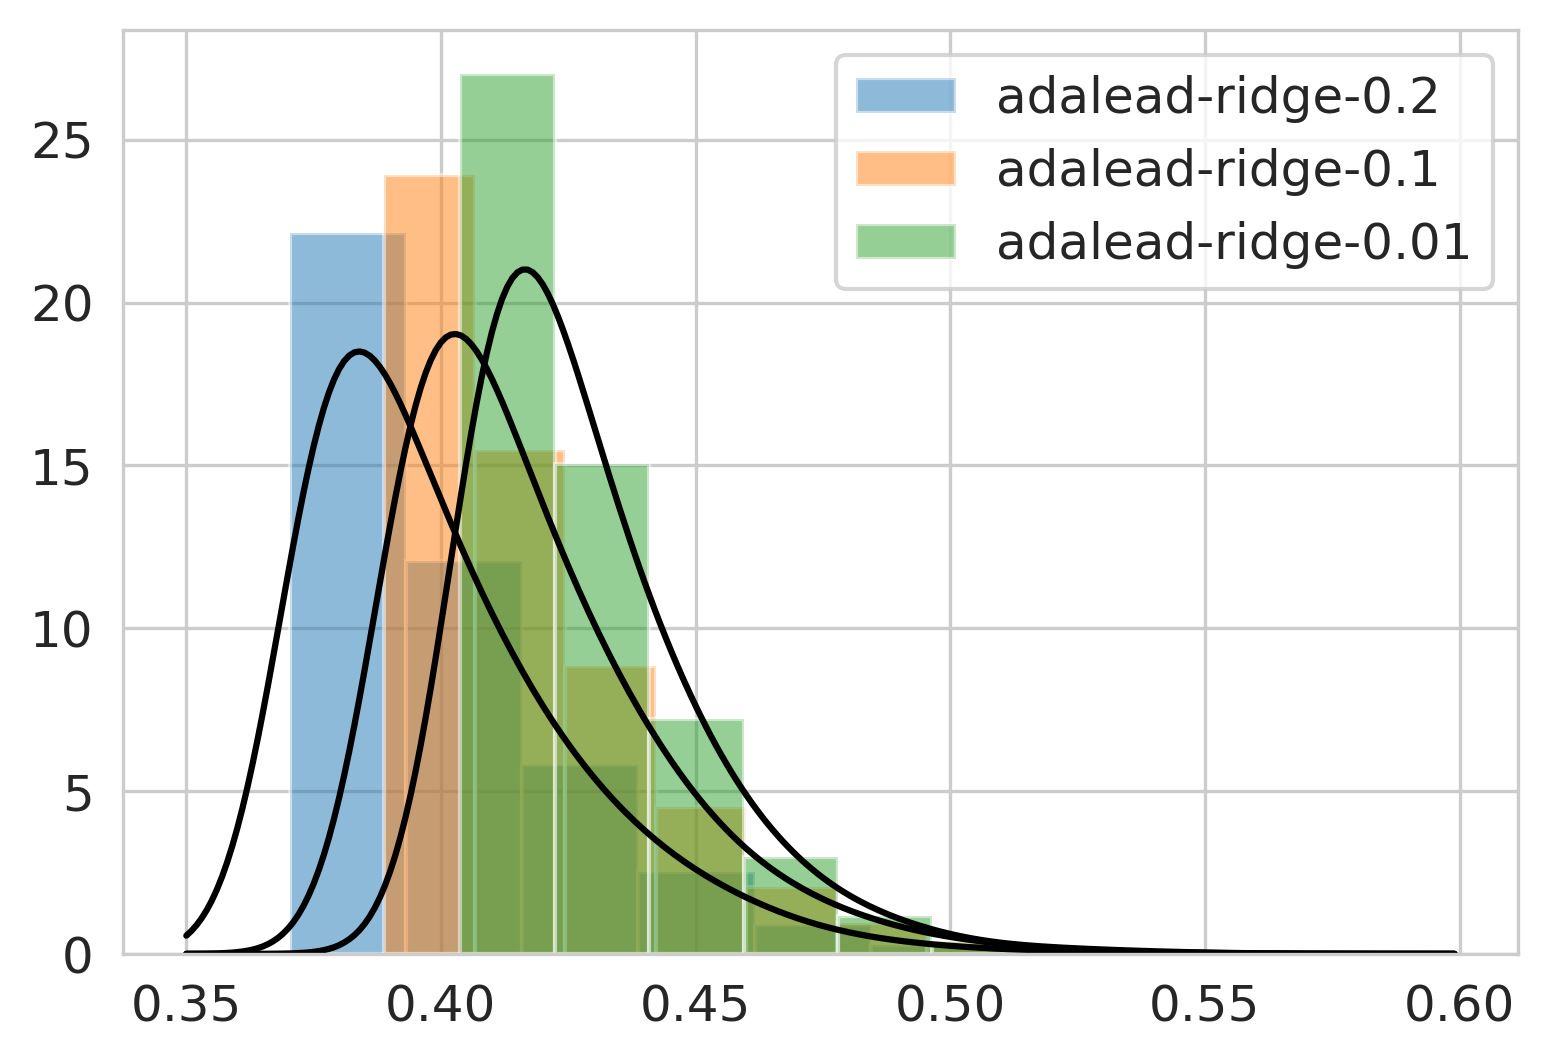

In [6]:
plt.figure(figsize=(6, 4), dpi=300)
kde = KernelDensity(bandwidth=0.01, kernel='gaussian', metric='euclidean')
xs = np.arange(0.35, 0.6, 0.001)[:, None]

for name, data in name2designdata.items():
    print(name)
    
    if data[2] is not None:
        if int(name[-1]) != 5 and int(name[-1]) < 3:
            
            plt.hist(data[2], alpha=0.5, label=name, density=True)
            kde.fit(data[2][:, None])
            p = np.exp(kde.score_samples(xs))
            plt.plot(xs, p, c='k')
            
plt.legend()

In [7]:
# prediction-based DRE

class PredictionDRE():
    def __init__(self, bandwidth: float = 0.01):
        self.bandwidth = bandwidth
        self.name2kde = {'train': KernelDensity(bandwidth=bandwidth, kernel='gaussian', metric='euclidean')}
    
    def fit(self, name2designdata):         
        for name, (_, _, pred_N) in name2designdata.items():
            if name != 'train':
                self.name2kde[name] = KernelDensity(bandwidth=self.bandwidth, kernel='gaussian', metric='euclidean')
                self.name2kde[name].fit(pred_N[:, None])
    
    def get_density_ratios(self, pred_n, name, self_normalize: bool = True):
        assert(name in self.name2kde)
        
        pred_nx1 = pred_n[:, None]
        self.name2kde['train'].fit(pred_nx1)
        
        logpdesign_n = self.name2kde[name].score_samples(pred_nx1)
        logpcal_n = self.name2kde['train'].score_samples(pred_nx1)
        
        dr_n = np.exp(logpdesign_n - logpcal_n)
        if self_normalize:
            dr_n = dr_n / np.sum(dr_n)
            
        return dr_n
    

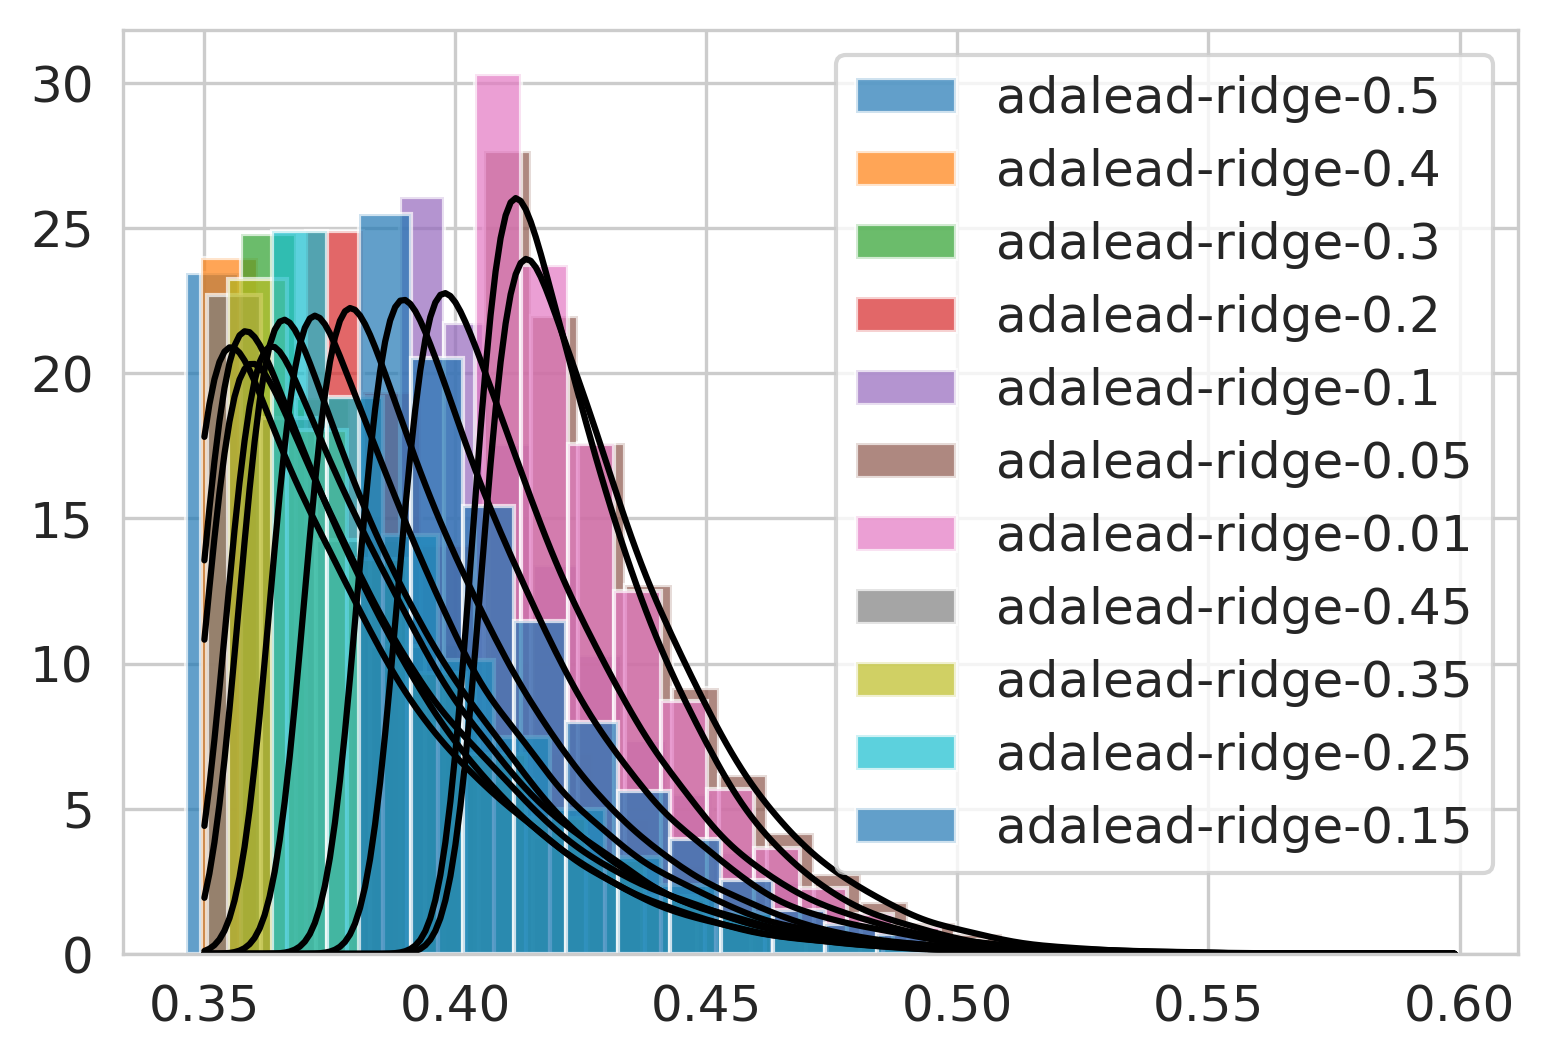

In [9]:
# DRE
bandwidth = 0.005

pdre = PredictionDRE(bandwidth=bandwidth)
pdre.fit(name2designdata)

# plot
plt.figure(figsize=(6, 4), dpi=300)
xs = np.arange(0.35, 0.6, 0.001)[:, None]

for name, kde in pdre.name2kde.items():
    if name != 'train':
        plt.hist(name2designdata[name][2], alpha=0.7, label=name, density=True, bins=20)
        pdesign_x = np.exp(kde.score_samples(xs))
        plt.plot(xs, pdesign_x, c='k')
            
plt.legend();

In [10]:
bandwidth = 0.005
name = 'adalead-ridge-0.5'

pdre = PredictionDRE(bandwidth=bandwidth)
pdre.fit(name2designdata)

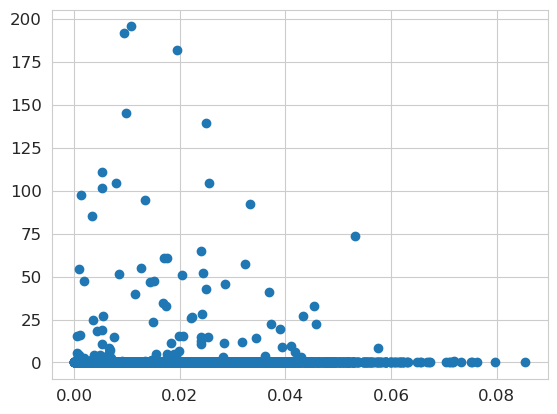

In [12]:
model_name = 'ridge'
model = name2model[model_name]
predcal_n = model.predict(calseqs_n)
caldr_n = pdre.get_density_ratios(predcal_n, name, self_normalize=False)

rescal_n = np.abs(ycal_n - predcal_n)
plt.scatter(rescal_n, caldr_n, s=5);

In [19]:
# point estimates
model_name = 'ridge'
alpha = 0.1
bandwidth = 0.005
self_normalize = True
target_values = np.arange(0.3, 0.51, 0.01)

pdre = PredictionDRE(bandwidth=bandwidth)
pdre.fit(name2designdata)

imp_target2name = {val: [] for val in target_values}
pp_target2name = {val: [] for val in target_values}
pointest_mx3 = np.zeros([len(name2designdata), 3])
ciwidth_mx2 = np.zeros([len(name2designdata), 2])
model = name2model[model_name]
predcal_n = model.predict(calseqs_n)

for i, data in enumerate(name2designdata.items()):
    
    design_name, (designseq_n, ydesign_n, preddesign_n) = data
    
    if design_name != 'train':
        print(design_name)
        
        imputed_mean = np.mean(preddesign_n)
        imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)
        
        caldr_n = pdre.get_density_ratios(predcal_n, design_name, self_normalize=self_normalize)
        rect_n = caldr_n * (ycal_n - predcal_n)
        
        rectifier_mean = np.mean(rect_n)
        rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
        pointest_mx3[i] = np.mean(ydesign_n), np.mean(preddesign_n) + rectifier_mean, np.mean(preddesign_n)
        
        pp_se = np.maximum(np.sqrt(imputed_se ** 2 + rectifier_se ** 2), 1e-16)
        ciwidth_mx2[i] = pp_se, imputed_se

        print('{:.3f} {:.3f} {:.3f}'.format(
            np.mean(ydesign_n), np.mean(preddesign_n), np.mean(preddesign_n) + rectifier_mean
        ))
        
        for target_val in target_values:

            # run imputation hypothesis test
            imp_pval = _zstat_generic(
                imputed_mean,
                0,
                imputed_se,
                alternative='larger',
                diff=target_val
            )[1]

            # run prediction-powered hypothesis test
            pp_pval = rectified_p_value(
                rectifier_mean,
                rectifier_se,
                imputed_mean,
                imputed_se,
                null=target_val,
                alternative='larger'
            )

            # Bonferroni correction
            if imp_pval < alpha / (len(name2designdata) - 1):
                imp_target2name[target_val].append(design_name)
                
            if pp_pval < alpha / (len(name2designdata) - 1):
                pp_target2name[target_val].append(design_name)
    else:
        train_idx = i
pointest_mx3 = np.delete(pointest_mx3, train_idx, axis=0)
ciwidth_mx2 = np.delete(ciwidth_mx2, train_idx, axis=0)

adalead-ridge-0.5
0.344 0.379 0.379
adalead-ridge-0.4
0.347 0.380 0.380
adalead-ridge-0.3
0.354 0.388 0.388
adalead-ridge-0.2
0.366 0.400 0.400
adalead-ridge-0.1
0.384 0.417 0.417
adalead-ridge-0.05
0.405 0.432 0.432
adalead-ridge-0.01
0.408 0.428 0.428
adalead-ridge-0.45
0.344 0.383 0.383
adalead-ridge-0.35
0.349 0.386 0.386
adalead-ridge-0.25
0.359 0.394 0.394
adalead-ridge-0.15
0.376 0.410 0.410


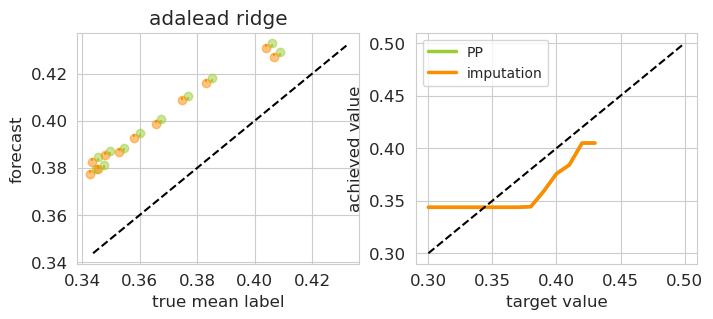

In [20]:
# run preliminary selection experiments and plot
title = f'adalead {model_name}'
ppoff = 0.001
impoff = -0.001

impach_t = []
ppach_t = []
xy_lim = [np.min(target_values), np.max(target_values)]

for val in target_values:
    names = imp_target2name[val]
    imp_truemeans = [np.mean(name2designdata[name][1]) for name in names]
    if len(imp_truemeans):
        impach_t.append(np.min(imp_truemeans))
    else:
        impach_t.append(np.nan)
    
    names = pp_target2name[val]
    pp_truemeans = [np.mean(name2designdata[name][1]) for name in names]
    if len(pp_truemeans):
        ppach_t.append(np.min(pp_truemeans))
    else:
        ppach_t.append(np.nan)

plt.figure(figsize=(8, 3))

plt.subplot(121)
plt.scatter(pointest_mx3[:, 0] + ppoff, pointest_mx3[:, 1] + ppoff, label='PP', c='yellowgreen', alpha=0.5)
plt.scatter(pointest_mx3[:, 0] + impoff, pointest_mx3[:, 2] + impoff, label='imputation', c='darkorange', alpha=0.5) 
for pe_x3, ciw_x2 in zip(pointest_mx3, ciwidth_mx2):
    plt.plot([pe_x3[0] + ppoff, pe_x3[0] + ppoff], [pe_x3[1] - 2 * ciw_x2[0], pe_x3[1] + 2 * ciw_x2[0]], c='yellowgreen')
    plt.plot([pe_x3[0] + impoff, pe_x3[0] + impoff], [pe_x3[2] - 2 * ciw_x2[1], pe_x3[2] + 2 * ciw_x2[1]], c='darkorange')

plt.plot([np.min(pointest_mx3), np.max(pointest_mx3)], [np.min(pointest_mx3), np.max(pointest_mx3)], '--k');
plt.xlabel('true mean label');
plt.ylabel('forecast');
plt.title(title);

plt.subplot(122)
plt.plot(target_values, ppach_t, label='PP', c='yellowgreen', linewidth=2.5)
plt.plot(target_values, impach_t, label='imputation', c='darkorange', linewidth=2.5)
plt.plot(xy_lim, xy_lim, '--k');
plt.xlabel('target value');
plt.ylabel('achieved value');
plt.legend(fontsize=10);

